In [3]:
import numpy as np
import cv2
import soundfile as sf
import scipy.io.wavfile as wavfile
from scipy.io.wavfile import write
import matplotlib.pyplot as plt

In [ ]:
# Primed the function to encode an image into sound

def encode_image_to_sound(image_path, output_filename="encoded_sound.wav", sample_rate=44100, min_freq=15000, max_freq=20000, duration_per_pixel=1/16, resolution=(128, 128)):
    # Load and resize image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, resolution)  # Higher resolution
    height, width = image.shape

    # Flatten image into a 1D array
    pixel_values = image.flatten()

    # Map pixel values to frequencies
    frequencies = np.interp(pixel_values, [0, 255], [min_freq, max_freq])

    # Generate the sound wave
    audio_wave = []

    for freq in frequencies:
        t = np.linspace(0, duration_per_pixel, int(sample_rate * duration_per_pixel), False)
        wave = 0.5 * np.sin(2 * np.pi * freq * t)  # Generate sine wave
        audio_wave.extend(wave)

    # Convert to 16-bit audio format
    audio_wave = np.array(audio_wave) * 32767
    audio_wave = audio_wave.astype(np.int16)

    # Save as a WAV file
    sf.write(output_filename, audio_wave, sample_rate)
    print(f"Encoded sound saved as {output_filename}")

    return audio_wave

# Example usage (for high resolution)
sound_wave = encode_image_to_sound(r"Images\Screenshot 2025-03-29 031229.png", resolution=(256, 256))


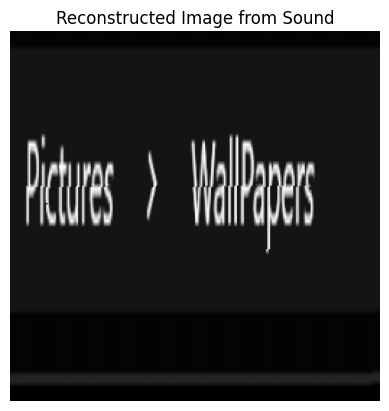

Reconstructed image saved as 'reconstructed_fixed_image.jpg'


array([[28, 28, 28, ..., 28, 28, 27],
       [28, 28, 28, ..., 28, 28, 27],
       [28, 28, 28, ..., 28, 28, 27],
       ...,
       [24, 24, 24, ..., 24, 24, 24],
       [24, 24, 24, ..., 24, 24, 24],
       [24, 24, 24, ..., 24, 24, 24]], dtype=uint8)

In [5]:
#Primer function to decode sound to image

def decode_sound_to_image2(audio_wave, sample_rate, original_resolution, min_freq=15000, max_freq=20000, duration_per_pixel=1/16):
    
    height, width = original_resolution
    expected_pixels = height * width  # Expected total number of pixels

    # Process audio to extract frequencies
    pixel_values = []

    for i in range(expected_pixels):
        start_idx = int(i * sample_rate * duration_per_pixel)
        end_idx = int((i + 1) * sample_rate * duration_per_pixel)

        if end_idx > len(audio_wave):
            break

        segment = audio_wave[start_idx:end_idx]

        # Perform frequency analysis using FFT (Better peak detection)
        spectrum = np.fft.fft(segment)
        freqs = np.fft.fftfreq(len(segment), d=1/sample_rate)

        # Find the dominant frequency with a robust selection method
        valid_indices = (freqs >= min_freq) & (freqs <= max_freq)
        if np.any(valid_indices):
            spectrum_magnitudes = np.abs(spectrum[valid_indices])
            peak_idx = np.argmax(spectrum_magnitudes)  
            dominant_freq = freqs[valid_indices][peak_idx]
        else:
            dominant_freq = min_freq  # Default if no valid peak found

        # Convert frequency back to pixel value
        pixel_value = np.interp(dominant_freq, [min_freq, max_freq], [0, 255])
        pixel_values.append(pixel_value)

    # Convert list to NumPy array
    pixel_values = np.array(pixel_values, dtype=np.uint8)

    # **Fix array size mismatch**
    actual_pixels = len(pixel_values)

    if actual_pixels < expected_pixels:
        # **Padding** if the array is too short
        pixel_values = np.pad(pixel_values, (0, expected_pixels - actual_pixels), mode='edge')
    elif actual_pixels > expected_pixels:
        # **Truncate** if the array is too long
        pixel_values = pixel_values[:expected_pixels]

    # Reshape into the original resolution
    image_reconstructed = pixel_values.reshape((height, width))

    # Save the reconstructed image
    cv2.imwrite("reconstructed_fixed_image.jpg", image_reconstructed)

    # Display the reconstructed image
    plt.imshow(image_reconstructed, cmap="gray")
    plt.title("Reconstructed Image from Sound")
    plt.axis("off")
    plt.show()

    print("Reconstructed image saved as 'reconstructed_fixed_image.jpg'")

    return image_reconstructed  # Return the image array

decode_sound_to_image2(sound_wave, 44100, (256, 256))  # Use the sample rate from encoding and original resolution